In [ ]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False
if IN_COLAB:
    !pip install -q transformers
    from google.colab import drive

    drive.mount('/content/drive')
    import sys

    sys.path.append('/content/drive/MyDrive/gan_bert_for_cpv')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 115.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 125.3 MB/s eta 0:00:00
Mounted at /content/drive


In [ ]:
from transformers import logging
logging.set_verbosity_error()
import torch
from create_dataset import CreateDataset
from process_data import ProcessData
from utils import *

from torch.utils.data import DataLoader
from run_model import RunModel
from models import BertGenerator, BertDiscriminator
from transformers import AutoTokenizer, AutoModel, AutoConfig

In [ ]:
from models import *

In [ ]:
label_column = "afdeling"
text_column = "Korte beschrijving aanbesteding"

In [ ]:
train_df = pd.read_csv("/content/drive/MyDrive/gan_bert_for_cpv/data/sampled_train.csv")
test_df = pd.read_csv("/content/drive/MyDrive/gan_bert_for_cpv/data/sampled_test.csv")
translate_back=pd.read_csv("/content/drive/MyDrive/gan_bert_for_cpv/data/translate_back_all.csv")
vc2 = train_df[label_column].value_counts()

In [ ]:
vc2

Furniture (incl. Meubelen (m.i.v. kantoormeubelen), inrichtingsartikelen, huishoudelijke apparaten (uitgez. verlichting) en schoonmaakproducten    970
Medische apparatuur, farmaceutische artikelen en artikelen voor lichaamsverzorging                                                                 970
Aardolieproducten, brandstof, elektriciteit en andere energiebronnen                                                                               970
Vervoersdiensten (uitg. vervoer van afval)                                                                                                         921
Diensten voor onderwijs en opleiding                                                                                                               841
Radio-, televisie-, communicatie-, telecommunicatietoestellen en aanverwante apparatuur                                                            816
Overige gemeenschaps-,  sociale en persoonlijke diensten                                      

In [ ]:
down_sample_vc = vc2[vc2.values <300]
train_df = train_df[train_df[label_column].isin(down_sample_vc.index)]
test_df=test_df[test_df[label_column].isin(down_sample_vc.index)]
translate_back=translate_back[translate_back[label_column].isin(down_sample_vc.index)]

In [ ]:
value_counts=train_df[label_column].value_counts()

In [ ]:
value_counts

Ondersteunende en aanvullende vervoersdiensten; reisbureaudiensten                                   227
Landbouw- en veeteelt-, kwekerij-, visserij-, bosbouw- en aanverwante producten                      214
Chemische producten                                                                                  167
Muziekinstrumenten, sportartikelen, spelletjes, speelgoed, handwerk, kunstartikelen en toebehoren    153
Installatiediensten (uitgezonderd software)                                                          139
Openbare voorzieningen                                                                               108
Landbouwmachines                                                                                      90
Mijnbouw, basismetalen en aanverwante producten                                                       33
Machines voor de mijnbouw, steengroeven en voor de bouw                                               29
Name: afdeling, dtype: int64

In [ ]:
all_df=pd.concat([train_df,test_df])

In [ ]:
running_device = torch.device("cuda")

In [ ]:
prd = ProcessData(all_df, label_column, text_column, sample_num=1000, aug_limit=1000, test_per_label_num=30,
                  drop_limit=50,
                  balanced_test=True)
_,_,_, label_encoder, onehot = prd.process()

After removing duplicate sentence: 1430
After drop cpv with low observations we have : 1430
The num of class is  9
The number of total data is:  1430
Total number of test data is:  270
Total number of train data is:  1152


In [ ]:
model_runner = RunModel(running_device)
cd = CreateDataset(text_column, label_column, label_encoder, onehot, 3, running_device, max_length=120)
test_dataset = cd.create(test_df)
test_dl = DataLoader(test_dataset, shuffle=True, batch_size=20)
insuf_ds_dict = cd.create_label_dataset(train_df)
insuf_ds_list = list(insuf_ds_dict.values())

Init new bert


Getting bert hidden states from layer: 3: 100%|██████████| 139/139 [00:01<00:00, 79.43it/s]


In [ ]:
tokenizer = AutoTokenizer.from_pretrained("GroNLP/bert-base-dutch-cased")
config = AutoConfig.from_pretrained("GroNLP/bert-base-dutch-cased", output_hidden_states=True)
bert = AutoModel.from_pretrained("GroNLP/bert-base-dutch-cased", config=config).to(running_device)

In [17]:
tbk_acc,gan_acc,hybrid_acc = [],[],[]
tbk_f1,gan_f1,hybrid_f1 = [],[],[]
tbk_recall,gan_recall,hybrid_recall = [],[],[]
tbk_precision,gan_precision,hybrid_precision = [],[],[]
tbk_all,gan_all,hybrid_all = [],[],[]
for i in range(1,11):
  sampled_df=translate_back.groupby(label_column, sort=False).sample(frac=float(i/20))
  sub_sample=sampled_df.groupby(label_column, sort=False).sample(frac=float(1/2))
  aug_limits = decide_aug_labels(False, None, value_counts,0.2*i)
  augmented_ds_lists = model_runner.augment_data(bert, aug_limits, insuf_ds_dict)
  half_augmented_ds_lists=[]
  for dataset in augmented_ds_lists:
      evens = list(range(0, len(dataset), 2))
      subdataset = torch.utils.data.Subset(dataset, evens)
      half_augmented_ds_lists.append(subdataset)
  tbk_aug_dataset = cd.create(sampled_df)
  sub_tbk_aug=cd.create(sub_sample)
  tbk_aug_train = torch.utils.data.ConcatDataset(insuf_ds_list+[tbk_aug_dataset])
  print(len(tbk_aug_train))
  gan_aug_train = torch.utils.data.ConcatDataset(insuf_ds_list+augmented_ds_lists)
  print(len(gan_aug_train))
  hybrid_train = torch.utils.data.ConcatDataset(insuf_ds_list+half_augmented_ds_lists+[sub_tbk_aug])
  print(len(hybrid_train))
  tbk_aug_dl = DataLoader(tbk_aug_train, shuffle=True, batch_size=40)

  gan_aug_dl = DataLoader(gan_aug_train, shuffle=True, batch_size=40)

  hybrid_dl = DataLoader(hybrid_train, shuffle=True, batch_size=40)

  classifier = HiddenClassifier3(prd.num_class, bert)
  classifier = model_runner.train_classifier(tbk_aug_dl, test_dl, classifier, lr=3e-5, n_epochs=10)
  predictions, labels = model_runner.predict(test_dl, classifier)
  acc, f1, precision, recall, label_f1 = evaluate(labels, predictions)
  tbk_acc.append(acc)
  tbk_f1.append(f1)
  tbk_recall.append(recall)
  tbk_precision.append(precision)
  tbk_all.append(label_f1)

  classifier = HiddenClassifier3(prd.num_class, bert)
  classifier = model_runner.train_classifier(gan_aug_dl, test_dl, classifier, lr=3e-5, n_epochs=10)
  predictions, labels = model_runner.predict(test_dl, classifier)
  acc, f1, precision, recall, label_f1 = evaluate(labels, predictions)
  gan_acc.append(acc)
  gan_f1.append(f1)
  gan_recall.append(recall)
  gan_precision.append(precision)
  gan_all.append(label_f1)
  classifier = HiddenClassifier3(prd.num_class, bert)
  classifier = model_runner.train_classifier(hybrid_dl, test_dl, classifier, lr=3e-5, n_epochs=10)
  predictions, labels = model_runner.predict(test_dl, classifier)
  acc, f1, precision, recall, label_f1 = evaluate(labels, predictions)

  hybrid_acc.append(acc)
  hybrid_f1.append(f1)
  hybrid_recall.append(recall)
  hybrid_precision.append(precision)
  hybrid_all.append(label_f1)


We have: 9 labels to be augmented


Getting bert hidden states from layer: 3: 100%|██████████| 117/117 [00:01<00:00, 80.05it/s]


1393
1380
1387


100%|██████████| 35/35 [00:19<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.111
F1: 0.022
Precision: 0.012
Recall: 0.111
0 acc:  0.1111111111111111 f1:  0.02222222222222222 precision 0.012345679012345678 recall 0.1111111111111111


100%|██████████| 35/35 [00:19<00:00,  1.78it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.111
F1: 0.022
Precision: 0.012
Recall: 0.111
1 acc:  0.1111111111111111 f1:  0.022296544035674472 precision 0.012391573729863693 recall 0.1111111111111111


100%|██████████| 35/35 [00:19<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.381
F1: 0.247
Precision: 0.195
Recall: 0.381
2 acc:  0.3814814814814815 f1:  0.2465562875154366 precision 0.19508323808919473 recall 0.38148148148148153


100%|██████████| 35/35 [00:19<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.400
F1: 0.271
Precision: 0.258
Recall: 0.400
3 acc:  0.4 f1:  0.2711353490054276 precision 0.25841710645342253 recall 0.4


100%|██████████| 35/35 [00:19<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.493
F1: 0.364
Precision: 0.341
Recall: 0.493
4 acc:  0.4925925925925926 f1:  0.3644122546909625 precision 0.34115116558519587 recall 0.49259259259259264


100%|██████████| 35/35 [00:19<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.541
F1: 0.433
Precision: 0.362
Recall: 0.541
5 acc:  0.5407407407407407 f1:  0.43301861497796607 precision 0.3618068858486977 recall 0.5407407407407407


100%|██████████| 35/35 [00:19<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.537
F1: 0.452
Precision: 0.413
Recall: 0.537
6 acc:  0.5370370370370371 f1:  0.45154650635069576 precision 0.4131743550882511 recall 0.5370370370370371


100%|██████████| 35/35 [00:19<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.519
F1: 0.429
Precision: 0.385
Recall: 0.519
7 acc:  0.5185185185185185 f1:  0.4291181807934845 precision 0.38461782009239 recall 0.5185185185185186


100%|██████████| 35/35 [00:19<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.544
F1: 0.467
Precision: 0.440
Recall: 0.544
8 acc:  0.5444444444444444 f1:  0.4673470862958377 precision 0.4404234816495353 recall 0.5444444444444445


100%|██████████| 35/35 [00:19<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.604
F1: 0.523
Precision: 0.468
Recall: 0.604
9 acc:  0.6037037037037037 f1:  0.5228774370621266 precision 0.4683316789921693 recall 0.6037037037037037


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.604
F1: 0.523
Precision: 0.468
Recall: 0.604


100%|██████████| 35/35 [00:19<00:00,  1.78it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.122
F1: 0.040
Precision: 0.046
Recall: 0.122
0 acc:  0.12222222222222222 f1:  0.0396551724137931 precision 0.04615384615384615 recall 0.12222222222222223


100%|██████████| 35/35 [00:19<00:00,  1.78it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.170
F1: 0.067
Precision: 0.074
Recall: 0.170
1 acc:  0.17037037037037037 f1:  0.06733551049340522 precision 0.07412013483240165 recall 0.17037037037037037


100%|██████████| 35/35 [00:19<00:00,  1.78it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.404
F1: 0.301
Precision: 0.346
Recall: 0.404
2 acc:  0.40370370370370373 f1:  0.30102795916250674 precision 0.34584430291352053 recall 0.4037037037037037


100%|██████████| 35/35 [00:19<00:00,  1.78it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.519
F1: 0.427
Precision: 0.380
Recall: 0.519
3 acc:  0.5185185185185185 f1:  0.4267094152817752 precision 0.3802316741274652 recall 0.5185185185185186


100%|██████████| 35/35 [00:19<00:00,  1.78it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.559
F1: 0.453
Precision: 0.386
Recall: 0.559
4 acc:  0.5592592592592592 f1:  0.4528548870899618 precision 0.38554533150236797 recall 0.5592592592592592


100%|██████████| 35/35 [00:19<00:00,  1.78it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.578
F1: 0.470
Precision: 0.403
Recall: 0.578
5 acc:  0.5777777777777777 f1:  0.4703251899845562 precision 0.4027369871758662 recall 0.5777777777777778


100%|██████████| 35/35 [00:19<00:00,  1.78it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.644
F1: 0.577
Precision: 0.613
Recall: 0.644
6 acc:  0.6444444444444445 f1:  0.5770062611970734 precision 0.6128661061065602 recall 0.6444444444444444


100%|██████████| 35/35 [00:19<00:00,  1.78it/s]


Total ACC: 0.659
F1: 0.632
Precision: 0.694
Recall: 0.659
7 acc:  0.6592592592592592 f1:  0.6321625942269526 precision 0.6936529331098201 recall 0.6592592592592592


100%|██████████| 35/35 [00:19<00:00,  1.77it/s]


Total ACC: 0.674
F1: 0.637
Precision: 0.721
Recall: 0.674
8 acc:  0.674074074074074 f1:  0.6365860990860991 precision 0.7213244503383748 recall 0.674074074074074


100%|██████████| 35/35 [00:19<00:00,  1.77it/s]


Total ACC: 0.726
F1: 0.710
Precision: 0.739
Recall: 0.726
9 acc:  0.725925925925926 f1:  0.7104756393819673 precision 0.7389755332596306 recall 0.725925925925926
Total ACC: 0.726
F1: 0.710
Precision: 0.739
Recall: 0.726


100%|██████████| 35/35 [00:19<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.126
F1: 0.045
Precision: 0.028
Recall: 0.126
0 acc:  0.1259259259259259 f1:  0.04540963237196206 precision 0.027995788358557965 recall 0.1259259259259259


100%|██████████| 35/35 [00:19<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.185
F1: 0.078
Precision: 0.053
Recall: 0.185
1 acc:  0.18518518518518517 f1:  0.07760009531653897 precision 0.053462571737131946 recall 0.18518518518518517


100%|██████████| 35/35 [00:19<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.415
F1: 0.336
Precision: 0.316
Recall: 0.415
2 acc:  0.4148148148148148 f1:  0.33601852404690363 precision 0.3159248388350555 recall 0.4148148148148148


100%|██████████| 35/35 [00:19<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.474
F1: 0.378
Precision: 0.323
Recall: 0.474
3 acc:  0.4740740740740741 f1:  0.37820674548911737 precision 0.3229328885675635 recall 0.4740740740740741


100%|██████████| 35/35 [00:19<00:00,  1.78it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.478
F1: 0.381
Precision: 0.332
Recall: 0.478
4 acc:  0.4777777777777778 f1:  0.38139911440715485 precision 0.33234869936468203 recall 0.47777777777777775


100%|██████████| 35/35 [00:19<00:00,  1.78it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.493
F1: 0.418
Precision: 0.474
Recall: 0.493
5 acc:  0.4925925925925926 f1:  0.41758115648113775 precision 0.47397741096858 recall 0.49259259259259264


100%|██████████| 35/35 [00:19<00:00,  1.78it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.533
F1: 0.464
Precision: 0.418
Recall: 0.533
6 acc:  0.5333333333333333 f1:  0.4636838664891717 precision 0.41811140978285616 recall 0.5333333333333334


100%|██████████| 35/35 [00:19<00:00,  1.78it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.563
F1: 0.498
Precision: 0.545
Recall: 0.563
7 acc:  0.562962962962963 f1:  0.49786387191176806 precision 0.5449454914173657 recall 0.5629629629629629


100%|██████████| 35/35 [00:19<00:00,  1.78it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.652
F1: 0.607
Precision: 0.589
Recall: 0.652
8 acc:  0.6518518518518519 f1:  0.6074347657956776 precision 0.588537898666099 recall 0.6518518518518519


100%|██████████| 35/35 [00:19<00:00,  1.78it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.656
F1: 0.608
Precision: 0.592
Recall: 0.656
9 acc:  0.6555555555555556 f1:  0.6077089219895293 precision 0.5923231049704576 recall 0.6555555555555556


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.656
F1: 0.608
Precision: 0.592
Recall: 0.656
We have: 9 labels to be augmented


Getting bert hidden states from layer: 3: 100%|██████████| 233/233 [00:02<00:00, 81.04it/s]


1625
1580
1603


100%|██████████| 41/41 [00:23<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.122
F1: 0.044
Precision: 0.027
Recall: 0.122
0 acc:  0.12222222222222222 f1:  0.044191199746755304 precision 0.027224627224627224 recall 0.12222222222222223


100%|██████████| 41/41 [00:23<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.156
F1: 0.065
Precision: 0.046
Recall: 0.156
1 acc:  0.15555555555555556 f1:  0.06457739791073125 precision 0.04642142142142142 recall 0.15555555555555556


100%|██████████| 41/41 [00:23<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.381
F1: 0.247
Precision: 0.191
Recall: 0.381
2 acc:  0.3814814814814815 f1:  0.24698856998515994 precision 0.1908922053234447 recall 0.38148148148148153


100%|██████████| 41/41 [00:23<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.489
F1: 0.389
Precision: 0.363
Recall: 0.489
3 acc:  0.4888888888888889 f1:  0.3890480104577515 precision 0.36264318039096904 recall 0.48888888888888893


100%|██████████| 41/41 [00:23<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.556
F1: 0.445
Precision: 0.374
Recall: 0.556
4 acc:  0.5555555555555556 f1:  0.4453982708575295 precision 0.37395453474272167 recall 0.5555555555555556


100%|██████████| 41/41 [00:23<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.563
F1: 0.472
Precision: 0.423
Recall: 0.563
5 acc:  0.562962962962963 f1:  0.4724839549825458 precision 0.42344984552245424 recall 0.5629629629629629


100%|██████████| 41/41 [00:23<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.611
F1: 0.528
Precision: 0.475
Recall: 0.611
6 acc:  0.6111111111111112 f1:  0.5275305298643707 precision 0.47533047730460193 recall 0.6111111111111112


100%|██████████| 41/41 [00:23<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.604
F1: 0.520
Precision: 0.482
Recall: 0.604
7 acc:  0.6037037037037037 f1:  0.52032093338145 precision 0.48248818672406707 recall 0.6037037037037036


100%|██████████| 41/41 [00:23<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.637
F1: 0.582
Precision: 0.589
Recall: 0.637
8 acc:  0.6370370370370371 f1:  0.581770411784437 precision 0.5885406473615693 recall 0.637037037037037


100%|██████████| 41/41 [00:23<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.685
F1: 0.639
Precision: 0.613
Recall: 0.685
9 acc:  0.6851851851851852 f1:  0.6387089535384319 precision 0.6127736600495998 recall 0.6851851851851851


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.685
F1: 0.639
Precision: 0.613
Recall: 0.685


100%|██████████| 40/40 [00:22<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.122
F1: 0.039
Precision: 0.043
Recall: 0.122
0 acc:  0.12222222222222222 f1:  0.03932821335133767 precision 0.04317304317304317 recall 0.12222222222222223


100%|██████████| 40/40 [00:22<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.204
F1: 0.126
Precision: 0.132
Recall: 0.204
1 acc:  0.2037037037037037 f1:  0.12598617649779045 precision 0.13171381887074168 recall 0.20370370370370372


100%|██████████| 40/40 [00:22<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.374
F1: 0.236
Precision: 0.176
Recall: 0.374
2 acc:  0.37407407407407406 f1:  0.2362468613717457 precision 0.1762046114742193 recall 0.37407407407407406


100%|██████████| 40/40 [00:22<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.507
F1: 0.439
Precision: 0.435
Recall: 0.507
3 acc:  0.5074074074074074 f1:  0.43912697324462036 precision 0.4354129587253157 recall 0.5074074074074075


100%|██████████| 40/40 [00:22<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.559
F1: 0.499
Precision: 0.470
Recall: 0.559
4 acc:  0.5592592592592592 f1:  0.49934711639490004 precision 0.46978229983305564 recall 0.5592592592592593


100%|██████████| 40/40 [00:22<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.593
F1: 0.521
Precision: 0.470
Recall: 0.593
5 acc:  0.5925925925925926 f1:  0.5213114904264484 precision 0.47030555977871014 recall 0.5925925925925927


100%|██████████| 40/40 [00:22<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.637
F1: 0.572
Precision: 0.579
Recall: 0.637
6 acc:  0.6370370370370371 f1:  0.5723157508223314 precision 0.5790046822482563 recall 0.6370370370370372


100%|██████████| 40/40 [00:22<00:00,  1.77it/s]


Total ACC: 0.678
F1: 0.648
Precision: 0.664
Recall: 0.678
7 acc:  0.6777777777777778 f1:  0.6484938071847893 precision 0.6640145382561422 recall 0.6777777777777777


100%|██████████| 40/40 [00:22<00:00,  1.77it/s]


Total ACC: 0.674
F1: 0.658
Precision: 0.664
Recall: 0.674
8 acc:  0.674074074074074 f1:  0.6576720970897629 precision 0.6642414094026997 recall 0.6740740740740742


100%|██████████| 40/40 [00:22<00:00,  1.77it/s]


Total ACC: 0.637
F1: 0.607
Precision: 0.635
Recall: 0.637
9 acc:  0.6370370370370371 f1:  0.607278866826632 precision 0.6350482421006369 recall 0.637037037037037
Total ACC: 0.637
F1: 0.607
Precision: 0.635
Recall: 0.637


100%|██████████| 41/41 [00:23<00:00,  1.78it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.159
F1: 0.058
Precision: 0.035
Recall: 0.159
0 acc:  0.15925925925925927 f1:  0.05772005772005771 precision 0.03528992978838316 recall 0.15925925925925927


100%|██████████| 41/41 [00:23<00:00,  1.78it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.230
F1: 0.126
Precision: 0.091
Recall: 0.230
1 acc:  0.22962962962962963 f1:  0.12597161408907084 precision 0.09128786906564684 recall 0.2296296296296296


100%|██████████| 41/41 [00:23<00:00,  1.78it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.393
F1: 0.249
Precision: 0.288
Recall: 0.393
2 acc:  0.3925925925925926 f1:  0.24883908239643007 precision 0.2879323173440821 recall 0.3925925925925926


100%|██████████| 41/41 [00:23<00:00,  1.78it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.452
F1: 0.349
Precision: 0.294
Recall: 0.452
3 acc:  0.45185185185185184 f1:  0.34948405200377386 precision 0.29434946118930116 recall 0.45185185185185184


100%|██████████| 41/41 [00:23<00:00,  1.78it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.444
F1: 0.350
Precision: 0.309
Recall: 0.444
4 acc:  0.4444444444444444 f1:  0.3499525396308352 precision 0.30861024688157174 recall 0.4444444444444444


100%|██████████| 41/41 [00:23<00:00,  1.78it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.541
F1: 0.454
Precision: 0.425
Recall: 0.541
5 acc:  0.5407407407407407 f1:  0.4538521206225121 precision 0.4253663840300019 recall 0.5407407407407407


100%|██████████| 41/41 [00:23<00:00,  1.78it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.585
F1: 0.512
Precision: 0.467
Recall: 0.585
6 acc:  0.5851851851851851 f1:  0.5121369899465431 precision 0.4666302844728983 recall 0.5851851851851851


100%|██████████| 41/41 [00:23<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.626
F1: 0.546
Precision: 0.490
Recall: 0.626
7 acc:  0.6259259259259259 f1:  0.5463413992653101 precision 0.4899713998335419 recall 0.6259259259259259


100%|██████████| 41/41 [00:23<00:00,  1.78it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.604
F1: 0.548
Precision: 0.602
Recall: 0.604
8 acc:  0.6037037037037037 f1:  0.5482909290624077 precision 0.6024990098332684 recall 0.6037037037037037


100%|██████████| 41/41 [00:23<00:00,  1.78it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.622
F1: 0.583
Precision: 0.591
Recall: 0.622
9 acc:  0.6222222222222222 f1:  0.5825957986287145 precision 0.5910340367046649 recall 0.6222222222222222


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.622
F1: 0.583
Precision: 0.591
Recall: 0.622
We have: 9 labels to be augmented


Getting bert hidden states from layer: 3: 100%|██████████| 347/347 [00:04<00:00, 81.27it/s]


1855
1800
1827


100%|██████████| 47/47 [00:26<00:00,  1.78it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.133
F1: 0.056
Precision: 0.073
Recall: 0.133
0 acc:  0.13333333333333333 f1:  0.055588375952963696 precision 0.07347607347607348 recall 0.13333333333333333


100%|██████████| 47/47 [00:26<00:00,  1.78it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.337
F1: 0.245
Precision: 0.276
Recall: 0.337
1 acc:  0.337037037037037 f1:  0.2445181356471679 precision 0.2755053588386922 recall 0.337037037037037


100%|██████████| 47/47 [00:26<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.515
F1: 0.426
Precision: 0.385
Recall: 0.515
2 acc:  0.5148148148148148 f1:  0.42571686601737757 precision 0.3849649660877823 recall 0.5148148148148147


100%|██████████| 47/47 [00:26<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.559
F1: 0.459
Precision: 0.396
Recall: 0.559
3 acc:  0.5592592592592592 f1:  0.4588961306119643 precision 0.3961280450685963 recall 0.5592592592592592


100%|██████████| 47/47 [00:26<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.552
F1: 0.448
Precision: 0.382
Recall: 0.552
4 acc:  0.5518518518518518 f1:  0.44791496892405847 precision 0.3817385119319518 recall 0.5518518518518518


100%|██████████| 47/47 [00:26<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.574
F1: 0.471
Precision: 0.411
Recall: 0.574
5 acc:  0.5740740740740741 f1:  0.470750211645734 precision 0.4106123981123981 recall 0.5740740740740741


100%|██████████| 47/47 [00:26<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.574
F1: 0.494
Precision: 0.444
Recall: 0.574
6 acc:  0.5740740740740741 f1:  0.4943677865447858 precision 0.4438715069149851 recall 0.5740740740740741


100%|██████████| 47/47 [00:26<00:00,  1.77it/s]


Total ACC: 0.622
F1: 0.574
Precision: 0.624
Recall: 0.622
7 acc:  0.6222222222222222 f1:  0.5735558394956279 precision 0.6237579641903902 recall 0.6222222222222222


100%|██████████| 47/47 [00:26<00:00,  1.77it/s]


Total ACC: 0.630
F1: 0.564
Precision: 0.717
Recall: 0.630
8 acc:  0.6296296296296297 f1:  0.5639261630470837 precision 0.7170434004029598 recall 0.6296296296296295


100%|██████████| 47/47 [00:26<00:00,  1.77it/s]


Total ACC: 0.615
F1: 0.568
Precision: 0.680
Recall: 0.615
9 acc:  0.6148148148148148 f1:  0.5677231633946442 precision 0.6804171991702918 recall 0.6148148148148148
Total ACC: 0.615
F1: 0.568
Precision: 0.680
Recall: 0.615


100%|██████████| 45/45 [00:25<00:00,  1.78it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.141
F1: 0.061
Precision: 0.065
Recall: 0.141
0 acc:  0.14074074074074075 f1:  0.06138218513227911 precision 0.06546281226588131 recall 0.14074074074074072


100%|██████████| 45/45 [00:25<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.289
F1: 0.179
Precision: 0.138
Recall: 0.289
1 acc:  0.28888888888888886 f1:  0.17921297451181695 precision 0.13764396992732206 recall 0.28888888888888886


100%|██████████| 45/45 [00:25<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.407
F1: 0.275
Precision: 0.277
Recall: 0.407
2 acc:  0.4074074074074074 f1:  0.27536588665708034 precision 0.2765435433064464 recall 0.4074074074074074


100%|██████████| 45/45 [00:25<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.552
F1: 0.462
Precision: 0.414
Recall: 0.552
3 acc:  0.5518518518518518 f1:  0.4619490956187632 precision 0.41355503327791593 recall 0.5518518518518518


100%|██████████| 45/45 [00:25<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.563
F1: 0.465
Precision: 0.411
Recall: 0.563
4 acc:  0.562962962962963 f1:  0.4647577637596828 precision 0.41120545268997355 recall 0.562962962962963


100%|██████████| 45/45 [00:25<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.559
F1: 0.477
Precision: 0.445
Recall: 0.559
5 acc:  0.5592592592592592 f1:  0.4772364080092196 precision 0.445357847870545 recall 0.5592592592592592


100%|██████████| 45/45 [00:25<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.604
F1: 0.536
Precision: 0.484
Recall: 0.604
6 acc:  0.6037037037037037 f1:  0.5355674962292609 precision 0.4835050862450243 recall 0.6037037037037039


100%|██████████| 45/45 [00:25<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.541
F1: 0.505
Precision: 0.512
Recall: 0.541
7 acc:  0.5407407407407407 f1:  0.504983027634139 precision 0.5121692914633079 recall 0.5407407407407407


100%|██████████| 45/45 [00:25<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.622
F1: 0.574
Precision: 0.548
Recall: 0.622
8 acc:  0.6222222222222222 f1:  0.5742291166104864 precision 0.5478273646695905 recall 0.6222222222222222


100%|██████████| 45/45 [00:25<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.619
F1: 0.568
Precision: 0.542
Recall: 0.619
9 acc:  0.6185185185185185 f1:  0.5680464313627456 precision 0.5422628803301371 recall 0.6185185185185186


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.619
F1: 0.568
Precision: 0.542
Recall: 0.619


100%|██████████| 46/46 [00:25<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.122
F1: 0.044
Precision: 0.027
Recall: 0.122
0 acc:  0.12222222222222222 f1:  0.0441513375109494 precision 0.027176969882906375 recall 0.12222222222222223


100%|██████████| 46/46 [00:25<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.130
F1: 0.047
Precision: 0.029
Recall: 0.130
1 acc:  0.12962962962962962 f1:  0.047183690626313585 precision 0.029433317049340497 recall 0.12962962962962962


100%|██████████| 46/46 [00:25<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.352
F1: 0.227
Precision: 0.191
Recall: 0.352
2 acc:  0.35185185185185186 f1:  0.22684492948933188 precision 0.1913390136449422 recall 0.35185185185185186


100%|██████████| 46/46 [00:25<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.419
F1: 0.312
Precision: 0.259
Recall: 0.419
3 acc:  0.4185185185185185 f1:  0.3119032979902545 precision 0.25940350499174025 recall 0.4185185185185185


100%|██████████| 46/46 [00:25<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.559
F1: 0.480
Precision: 0.460
Recall: 0.559
4 acc:  0.5592592592592592 f1:  0.4802510894378797 precision 0.46041577087955055 recall 0.5592592592592593


100%|██████████| 46/46 [00:25<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.615
F1: 0.539
Precision: 0.511
Recall: 0.615
5 acc:  0.6148148148148148 f1:  0.5394038669650338 precision 0.5108417654811213 recall 0.6148148148148148


100%|██████████| 46/46 [00:25<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.604
F1: 0.533
Precision: 0.479
Recall: 0.604
6 acc:  0.6037037037037037 f1:  0.5325619927051224 precision 0.47925038581673335 recall 0.6037037037037037


100%|██████████| 46/46 [00:25<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.626
F1: 0.553
Precision: 0.508
Recall: 0.626
7 acc:  0.6259259259259259 f1:  0.5532241008303287 precision 0.5079784196743261 recall 0.625925925925926


100%|██████████| 46/46 [00:25<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.607
F1: 0.535
Precision: 0.492
Recall: 0.607
8 acc:  0.6074074074074074 f1:  0.5346225968518564 precision 0.49181143576492414 recall 0.6074074074074074


100%|██████████| 46/46 [00:25<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.626
F1: 0.553
Precision: 0.503
Recall: 0.626
9 acc:  0.6259259259259259 f1:  0.5528242628699249 precision 0.5027132643411714 recall 0.625925925925926


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.626
F1: 0.553
Precision: 0.503
Recall: 0.626
We have: 9 labels to be augmented


Getting bert hidden states from layer: 3: 100%|██████████| 465/465 [00:05<00:00, 83.06it/s]


2087
2020
2055


100%|██████████| 53/53 [00:29<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.111
F1: 0.022
Precision: 0.012
Recall: 0.111
0 acc:  0.1111111111111111 f1:  0.02222222222222222 precision 0.012345679012345678 recall 0.1111111111111111


100%|██████████| 53/53 [00:30<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.378
F1: 0.245
Precision: 0.291
Recall: 0.378
1 acc:  0.37777777777777777 f1:  0.24542845230673255 precision 0.29143754810809175 recall 0.37777777777777777


100%|██████████| 53/53 [00:30<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.537
F1: 0.435
Precision: 0.420
Recall: 0.537
2 acc:  0.5370370370370371 f1:  0.4354964934638585 precision 0.41996719825614437 recall 0.537037037037037


100%|██████████| 53/53 [00:30<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.585
F1: 0.504
Precision: 0.475
Recall: 0.585
3 acc:  0.5851851851851851 f1:  0.5043755050014673 precision 0.47544000214807663 recall 0.5851851851851851


100%|██████████| 53/53 [00:30<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.604
F1: 0.531
Precision: 0.481
Recall: 0.604
4 acc:  0.6037037037037037 f1:  0.5307278834388066 precision 0.48106686030068563 recall 0.6037037037037037


100%|██████████| 53/53 [00:30<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.607
F1: 0.536
Precision: 0.530
Recall: 0.607
5 acc:  0.6074074074074074 f1:  0.536060865281066 precision 0.5299316592182675 recall 0.6074074074074074


100%|██████████| 53/53 [00:30<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.648
F1: 0.591
Precision: 0.596
Recall: 0.648
6 acc:  0.6481481481481481 f1:  0.5911017594202828 precision 0.5962184578316686 recall 0.6481481481481481


100%|██████████| 53/53 [00:30<00:00,  1.77it/s]


Total ACC: 0.693
F1: 0.656
Precision: 0.742
Recall: 0.693
7 acc:  0.6925925925925925 f1:  0.6555364595039117 precision 0.7417366426317833 recall 0.6925925925925926


100%|██████████| 53/53 [00:30<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.700
F1: 0.657
Precision: 0.644
Recall: 0.700
8 acc:  0.7 f1:  0.6569168383553757 precision 0.6435627053476023 recall 0.7


100%|██████████| 53/53 [00:29<00:00,  1.77it/s]


Total ACC: 0.700
F1: 0.673
Precision: 0.727
Recall: 0.700
9 acc:  0.7 f1:  0.6728278026684067 precision 0.7274846474606866 recall 0.7000000000000001
Total ACC: 0.700
F1: 0.673
Precision: 0.727
Recall: 0.700


100%|██████████| 51/51 [00:28<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.111
F1: 0.022
Precision: 0.012
Recall: 0.111
0 acc:  0.1111111111111111 f1:  0.02222222222222222 precision 0.012345679012345678 recall 0.1111111111111111


100%|██████████| 51/51 [00:28<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.411
F1: 0.291
Precision: 0.231
Recall: 0.411
1 acc:  0.4111111111111111 f1:  0.29121089513246373 precision 0.2305806289848843 recall 0.41111111111111115


100%|██████████| 51/51 [00:28<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.559
F1: 0.481
Precision: 0.447
Recall: 0.559
2 acc:  0.5592592592592592 f1:  0.4807238125067582 precision 0.44709747611638867 recall 0.5592592592592593


100%|██████████| 51/51 [00:28<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.607
F1: 0.529
Precision: 0.477
Recall: 0.607
3 acc:  0.6074074074074074 f1:  0.5291901613145668 precision 0.4768959654764439 recall 0.6074074074074074


100%|██████████| 51/51 [00:28<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.593
F1: 0.519
Precision: 0.467
Recall: 0.593
4 acc:  0.5925925925925926 f1:  0.5187269151943066 precision 0.4670724954830086 recall 0.5925925925925927


100%|██████████| 51/51 [00:28<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.626
F1: 0.561
Precision: 0.536
Recall: 0.626
5 acc:  0.6259259259259259 f1:  0.5612195707734464 precision 0.5356873117618903 recall 0.625925925925926


100%|██████████| 51/51 [00:28<00:00,  1.76it/s]


Total ACC: 0.652
F1: 0.598
Precision: 0.592
Recall: 0.652
6 acc:  0.6518518518518519 f1:  0.5975789078553985 precision 0.5921595812996149 recall 0.6518518518518519


100%|██████████| 51/51 [00:28<00:00,  1.76it/s]


Total ACC: 0.700
F1: 0.679
Precision: 0.694
Recall: 0.700
7 acc:  0.7 f1:  0.6789166576502783 precision 0.694369695963468 recall 0.7000000000000001


100%|██████████| 51/51 [00:28<00:00,  1.76it/s]


Total ACC: 0.715
F1: 0.698
Precision: 0.719
Recall: 0.715
8 acc:  0.7148148148148148 f1:  0.6981101201320029 precision 0.7194606296454392 recall 0.7148148148148148


100%|██████████| 51/51 [00:28<00:00,  1.77it/s]


Total ACC: 0.726
F1: 0.716
Precision: 0.723
Recall: 0.726
9 acc:  0.725925925925926 f1:  0.7162448096499907 precision 0.7231400701412017 recall 0.7259259259259259
Total ACC: 0.726
F1: 0.716
Precision: 0.723
Recall: 0.726


100%|██████████| 52/52 [00:29<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.170
F1: 0.064
Precision: 0.040
Recall: 0.170
0 acc:  0.17037037037037037 f1:  0.06359848583283524 precision 0.039705373078664855 recall 0.17037037037037037


100%|██████████| 52/52 [00:29<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.437
F1: 0.317
Precision: 0.253
Recall: 0.437
1 acc:  0.43703703703703706 f1:  0.31682994173324697 precision 0.25322438324899355 recall 0.43703703703703706


100%|██████████| 52/52 [00:29<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.474
F1: 0.401
Precision: 0.410
Recall: 0.474
2 acc:  0.4740740740740741 f1:  0.40061591832042676 precision 0.4104777290962836 recall 0.4740740740740741


100%|██████████| 52/52 [00:29<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.600
F1: 0.526
Precision: 0.489
Recall: 0.600
3 acc:  0.6 f1:  0.5262995948616864 precision 0.48864308206413465 recall 0.6000000000000001


100%|██████████| 52/52 [00:29<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.600
F1: 0.525
Precision: 0.467
Recall: 0.600
4 acc:  0.6 f1:  0.5251816668696463 precision 0.4670265407107512 recall 0.6000000000000001


100%|██████████| 52/52 [00:29<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.585
F1: 0.511
Precision: 0.464
Recall: 0.585
5 acc:  0.5851851851851851 f1:  0.5105216901226771 precision 0.4640445295604522 recall 0.5851851851851851


100%|██████████| 52/52 [00:29<00:00,  1.78it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.615
F1: 0.535
Precision: 0.479
Recall: 0.615
6 acc:  0.6148148148148148 f1:  0.5345349114737089 precision 0.4788930534023105 recall 0.6148148148148148


100%|██████████| 52/52 [00:29<00:00,  1.78it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.644
F1: 0.590
Precision: 0.582
Recall: 0.644
7 acc:  0.6444444444444445 f1:  0.5899776040549419 precision 0.5820256627844704 recall 0.6444444444444445


100%|██████████| 52/52 [00:29<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.696
F1: 0.651
Precision: 0.622
Recall: 0.696
8 acc:  0.6962962962962963 f1:  0.651187025550543 precision 0.6216023051337144 recall 0.6962962962962963


100%|██████████| 52/52 [00:29<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.707
F1: 0.666
Precision: 0.632
Recall: 0.707
9 acc:  0.7074074074074074 f1:  0.6657951929844584 precision 0.6317442661433978 recall 0.7074074074074074


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.707
F1: 0.666
Precision: 0.632
Recall: 0.707
We have: 9 labels to be augmented


Getting bert hidden states from layer: 3: 100%|██████████| 580/580 [00:06<00:00, 83.05it/s]


2320
2220
2270


100%|██████████| 58/58 [00:32<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.204
F1: 0.119
Precision: 0.115
Recall: 0.204
0 acc:  0.2037037037037037 f1:  0.11914374552546993 precision 0.11463951815893562 recall 0.2037037037037037


100%|██████████| 58/58 [00:33<00:00,  1.75it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.444
F1: 0.318
Precision: 0.250
Recall: 0.444
1 acc:  0.4444444444444444 f1:  0.31767888082514684 precision 0.24970972180274506 recall 0.4444444444444444


100%|██████████| 58/58 [00:33<00:00,  1.75it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.507
F1: 0.435
Precision: 0.447
Recall: 0.507
2 acc:  0.5074074074074074 f1:  0.4345504428212007 precision 0.4466370078260199 recall 0.5074074074074074


100%|██████████| 58/58 [00:33<00:00,  1.75it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.615
F1: 0.537
Precision: 0.499
Recall: 0.615
3 acc:  0.6148148148148148 f1:  0.5368388035382003 precision 0.49877121912445715 recall 0.6148148148148148


100%|██████████| 58/58 [00:33<00:00,  1.75it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.644
F1: 0.565
Precision: 0.511
Recall: 0.644
4 acc:  0.6444444444444445 f1:  0.5650878364760075 precision 0.5108098402354652 recall 0.6444444444444444


100%|██████████| 58/58 [00:33<00:00,  1.75it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.633
F1: 0.569
Precision: 0.612
Recall: 0.633
5 acc:  0.6333333333333333 f1:  0.5685516714110403 precision 0.6119664556408253 recall 0.6333333333333333


100%|██████████| 58/58 [00:33<00:00,  1.75it/s]


Total ACC: 0.681
F1: 0.662
Precision: 0.709
Recall: 0.681
6 acc:  0.6814814814814815 f1:  0.6615622200568373 precision 0.709417770733721 recall 0.6814814814814816


100%|██████████| 58/58 [00:33<00:00,  1.75it/s]


Total ACC: 0.685
F1: 0.645
Precision: 0.723
Recall: 0.685
7 acc:  0.6851851851851852 f1:  0.6454628833212271 precision 0.7227994592136654 recall 0.6851851851851852


100%|██████████| 58/58 [00:33<00:00,  1.75it/s]


Total ACC: 0.715
F1: 0.701
Precision: 0.743
Recall: 0.715
8 acc:  0.7148148148148148 f1:  0.701040336705449 precision 0.7431139700980971 recall 0.7148148148148148


100%|██████████| 58/58 [00:33<00:00,  1.75it/s]


Total ACC: 0.707
F1: 0.689
Precision: 0.716
Recall: 0.707
9 acc:  0.7074074074074074 f1:  0.6885314891506842 precision 0.7157136073802741 recall 0.7074074074074075
Total ACC: 0.707
F1: 0.689
Precision: 0.716
Recall: 0.707


100%|██████████| 56/56 [00:31<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.144
F1: 0.066
Precision: 0.072
Recall: 0.144
0 acc:  0.14444444444444443 f1:  0.06611031751998597 precision 0.07199875997829962 recall 0.14444444444444446


100%|██████████| 56/56 [00:31<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.400
F1: 0.293
Precision: 0.241
Recall: 0.400
1 acc:  0.4 f1:  0.2932432820661608 precision 0.24096776670995623 recall 0.4


100%|██████████| 56/56 [00:31<00:00,  1.78it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.463
F1: 0.362
Precision: 0.309
Recall: 0.463
2 acc:  0.46296296296296297 f1:  0.3621138147699648 precision 0.30858018792801395 recall 0.462962962962963


100%|██████████| 56/56 [00:31<00:00,  1.78it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.500
F1: 0.400
Precision: 0.344
Recall: 0.500
3 acc:  0.5 f1:  0.3997159371681243 precision 0.3435362347647484 recall 0.4999999999999999


100%|██████████| 56/56 [00:31<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.596
F1: 0.521
Precision: 0.470
Recall: 0.596
4 acc:  0.5962962962962963 f1:  0.5206578063024164 precision 0.47019734301587435 recall 0.5962962962962962


100%|██████████| 56/56 [00:31<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.589
F1: 0.517
Precision: 0.482
Recall: 0.589
5 acc:  0.5888888888888889 f1:  0.5168090088465329 precision 0.48153643153643155 recall 0.588888888888889


100%|██████████| 56/56 [00:31<00:00,  1.76it/s]


Total ACC: 0.630
F1: 0.588
Precision: 0.670
Recall: 0.630
6 acc:  0.6296296296296297 f1:  0.5875636962924277 precision 0.6700798072853371 recall 0.6296296296296297


100%|██████████| 56/56 [00:31<00:00,  1.76it/s]


Total ACC: 0.615
F1: 0.575
Precision: 0.619
Recall: 0.615
7 acc:  0.6148148148148148 f1:  0.5748440539130271 precision 0.6192259874264933 recall 0.6148148148148148


100%|██████████| 56/56 [00:31<00:00,  1.76it/s]


Total ACC: 0.637
F1: 0.615
Precision: 0.638
Recall: 0.637
8 acc:  0.6370370370370371 f1:  0.6152106035773378 precision 0.6380491201712133 recall 0.6370370370370371


100%|██████████| 56/56 [00:31<00:00,  1.76it/s]


Total ACC: 0.652
F1: 0.632
Precision: 0.655
Recall: 0.652
9 acc:  0.6518518518518519 f1:  0.6323349275759357 precision 0.6545617523353134 recall 0.6518518518518519
Total ACC: 0.652
F1: 0.632
Precision: 0.655
Recall: 0.652


100%|██████████| 57/57 [00:32<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.111
F1: 0.022
Precision: 0.012
Recall: 0.111
0 acc:  0.1111111111111111 f1:  0.02222222222222222 precision 0.012345679012345678 recall 0.1111111111111111


100%|██████████| 57/57 [00:32<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.300
F1: 0.194
Precision: 0.300
Recall: 0.300
1 acc:  0.3 f1:  0.19449698589317085 precision 0.2999325095557617 recall 0.30000000000000004


100%|██████████| 57/57 [00:32<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.567
F1: 0.486
Precision: 0.447
Recall: 0.567
2 acc:  0.5666666666666667 f1:  0.4856797239021765 precision 0.4466972847572024 recall 0.5666666666666668


100%|██████████| 57/57 [00:32<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.585
F1: 0.508
Precision: 0.457
Recall: 0.585
3 acc:  0.5851851851851851 f1:  0.5077529306165238 precision 0.4574377217160792 recall 0.5851851851851851


100%|██████████| 57/57 [00:32<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.611
F1: 0.537
Precision: 0.484
Recall: 0.611
4 acc:  0.6111111111111112 f1:  0.5371007702692494 precision 0.48352410514015864 recall 0.6111111111111112


100%|██████████| 57/57 [00:32<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.619
F1: 0.540
Precision: 0.490
Recall: 0.619
5 acc:  0.6185185185185185 f1:  0.5399783366023659 precision 0.4902745869142903 recall 0.6185185185185185


100%|██████████| 57/57 [00:32<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.626
F1: 0.566
Precision: 0.538
Recall: 0.626
6 acc:  0.6259259259259259 f1:  0.5658099759875191 precision 0.5383444637014755 recall 0.6259259259259259


100%|██████████| 57/57 [00:32<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.633
F1: 0.594
Precision: 0.564
Recall: 0.633
7 acc:  0.6333333333333333 f1:  0.5935328955568836 precision 0.5644010310676977 recall 0.6333333333333333


100%|██████████| 57/57 [00:32<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.633
F1: 0.602
Precision: 0.586
Recall: 0.633
8 acc:  0.6333333333333333 f1:  0.6022952163016322 precision 0.586167866984897 recall 0.6333333333333334


100%|██████████| 57/57 [00:32<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.633
F1: 0.589
Precision: 0.553
Recall: 0.633
9 acc:  0.6333333333333333 f1:  0.588962978700515 precision 0.5529451069220204 recall 0.6333333333333333


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.633
F1: 0.589
Precision: 0.553
Recall: 0.633
We have: 9 labels to be augmented


Getting bert hidden states from layer: 3: 100%|██████████| 697/697 [00:08<00:00, 82.20it/s]


2553
2460
2507


100%|██████████| 64/64 [00:36<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.170
F1: 0.077
Precision: 0.059
Recall: 0.170
0 acc:  0.17037037037037037 f1:  0.0774476026414011 precision 0.05910609857978279 recall 0.17037037037037037


100%|██████████| 64/64 [00:36<00:00,  1.75it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.474
F1: 0.344
Precision: 0.275
Recall: 0.474
1 acc:  0.4740740740740741 f1:  0.3437316072774842 precision 0.27472243540607383 recall 0.47407407407407415


100%|██████████| 64/64 [00:36<00:00,  1.75it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.496
F1: 0.363
Precision: 0.293
Recall: 0.496
2 acc:  0.4962962962962963 f1:  0.36324248970114015 precision 0.2928259653963295 recall 0.4962962962962963


100%|██████████| 64/64 [00:36<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.530
F1: 0.414
Precision: 0.354
Recall: 0.530
3 acc:  0.5296296296296297 f1:  0.41423387434203296 precision 0.3535221375716537 recall 0.5296296296296297


100%|██████████| 64/64 [00:36<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.552
F1: 0.474
Precision: 0.435
Recall: 0.552
4 acc:  0.5518518518518518 f1:  0.47414840659616775 precision 0.43467391142829737 recall 0.5518518518518518


100%|██████████| 64/64 [00:36<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.567
F1: 0.498
Precision: 0.446
Recall: 0.567
5 acc:  0.5666666666666667 f1:  0.4976744626369627 precision 0.44616964089525063 recall 0.5666666666666667


100%|██████████| 64/64 [00:36<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.589
F1: 0.501
Precision: 0.476
Recall: 0.589
6 acc:  0.5888888888888889 f1:  0.5006949901524332 precision 0.475977538063493 recall 0.5888888888888889


100%|██████████| 64/64 [00:36<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.596
F1: 0.533
Precision: 0.501
Recall: 0.596
7 acc:  0.5962962962962963 f1:  0.5329255547396904 precision 0.5010833591394142 recall 0.5962962962962963


100%|██████████| 64/64 [00:36<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.567
F1: 0.500
Precision: 0.481
Recall: 0.567
8 acc:  0.5666666666666667 f1:  0.4995325233006393 precision 0.48082010582010576 recall 0.5666666666666667


100%|██████████| 64/64 [00:36<00:00,  1.75it/s]


Total ACC: 0.637
F1: 0.592
Precision: 0.674
Recall: 0.637
9 acc:  0.6370370370370371 f1:  0.59207412150221 precision 0.674013174013174 recall 0.6370370370370371
Total ACC: 0.637
F1: 0.592
Precision: 0.674
Recall: 0.637


100%|██████████| 62/62 [00:35<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.144
F1: 0.053
Precision: 0.033
Recall: 0.144
0 acc:  0.14444444444444443 f1:  0.053032015065913374 precision 0.032539682539682535 recall 0.14444444444444443


100%|██████████| 62/62 [00:35<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.526
F1: 0.446
Precision: 0.455
Recall: 0.526
1 acc:  0.5259259259259259 f1:  0.44601810380275747 precision 0.45518313833287316 recall 0.525925925925926


100%|██████████| 62/62 [00:35<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.548
F1: 0.483
Precision: 0.474
Recall: 0.548
2 acc:  0.5481481481481482 f1:  0.48313760492646346 precision 0.4742092435640823 recall 0.548148148148148


100%|██████████| 62/62 [00:35<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.622
F1: 0.542
Precision: 0.487
Recall: 0.622
3 acc:  0.6222222222222222 f1:  0.5421445993104146 precision 0.4867708949238485 recall 0.6222222222222222


100%|██████████| 62/62 [00:35<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.615
F1: 0.538
Precision: 0.485
Recall: 0.615
4 acc:  0.6148148148148148 f1:  0.538170577352596 precision 0.48496172940617377 recall 0.6148148148148148


100%|██████████| 62/62 [00:35<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.656
F1: 0.594
Precision: 0.623
Recall: 0.656
5 acc:  0.6555555555555556 f1:  0.5937667609457836 precision 0.6231576730156516 recall 0.6555555555555556


100%|██████████| 62/62 [00:35<00:00,  1.77it/s]


Total ACC: 0.693
F1: 0.664
Precision: 0.675
Recall: 0.693
6 acc:  0.6925925925925925 f1:  0.6641129425029995 precision 0.6749231873615176 recall 0.6925925925925926


100%|██████████| 62/62 [00:35<00:00,  1.76it/s]


Total ACC: 0.722
F1: 0.720
Precision: 0.732
Recall: 0.722
7 acc:  0.7222222222222222 f1:  0.7202657968054559 precision 0.7315660151367298 recall 0.7222222222222223


100%|██████████| 62/62 [00:35<00:00,  1.76it/s]


Total ACC: 0.707
F1: 0.692
Precision: 0.723
Recall: 0.707
8 acc:  0.7074074074074074 f1:  0.692161681500065 precision 0.7225255947628669 recall 0.7074074074074075


100%|██████████| 62/62 [00:35<00:00,  1.76it/s]


Total ACC: 0.678
F1: 0.680
Precision: 0.725
Recall: 0.678
9 acc:  0.6777777777777778 f1:  0.6797378960580223 precision 0.724653488129927 recall 0.6777777777777777
Total ACC: 0.678
F1: 0.680
Precision: 0.725
Recall: 0.678


100%|██████████| 63/63 [00:35<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.196
F1: 0.078
Precision: 0.063
Recall: 0.196
0 acc:  0.1962962962962963 f1:  0.07808524083033887 precision 0.06275814985492405 recall 0.1962962962962963


100%|██████████| 63/63 [00:35<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.400
F1: 0.283
Precision: 0.225
Recall: 0.400
1 acc:  0.4 f1:  0.2830623719577986 precision 0.22494976901756564 recall 0.4


100%|██████████| 63/63 [00:35<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.456
F1: 0.349
Precision: 0.309
Recall: 0.456
2 acc:  0.45555555555555555 f1:  0.34897903671213987 precision 0.30868917208102287 recall 0.4555555555555556


100%|██████████| 63/63 [00:35<00:00,  1.78it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.441
F1: 0.326
Precision: 0.266
Recall: 0.441
3 acc:  0.44074074074074077 f1:  0.32619746737326394 precision 0.26633811116409833 recall 0.44074074074074077


100%|██████████| 63/63 [00:35<00:00,  1.79it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.459
F1: 0.344
Precision: 0.287
Recall: 0.459
4 acc:  0.45925925925925926 f1:  0.34416916136651454 precision 0.28666332762914426 recall 0.4592592592592593


100%|██████████| 63/63 [00:35<00:00,  1.80it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.441
F1: 0.331
Precision: 0.284
Recall: 0.441
5 acc:  0.44074074074074077 f1:  0.33098124390421596 precision 0.2837062208407237 recall 0.44074074074074077


100%|██████████| 63/63 [00:35<00:00,  1.79it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.504
F1: 0.418
Precision: 0.367
Recall: 0.504
6 acc:  0.5037037037037037 f1:  0.4177659444127162 precision 0.3672225549153994 recall 0.5037037037037037


100%|██████████| 63/63 [00:35<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.522
F1: 0.453
Precision: 0.464
Recall: 0.522
7 acc:  0.5222222222222223 f1:  0.45251756912498364 precision 0.4635175584383643 recall 0.5222222222222223


100%|██████████| 63/63 [00:35<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.589
F1: 0.515
Precision: 0.466
Recall: 0.589
8 acc:  0.5888888888888889 f1:  0.5148110176358764 precision 0.4663810540247322 recall 0.5888888888888889


100%|██████████| 63/63 [00:35<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.581
F1: 0.512
Precision: 0.469
Recall: 0.581
9 acc:  0.5814814814814815 f1:  0.5115198203557078 precision 0.4689646628866403 recall 0.5814814814814815


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.581
F1: 0.512
Precision: 0.469
Recall: 0.581
We have: 9 labels to be augmented


Getting bert hidden states from layer: 3: 100%|██████████| 813/813 [00:09<00:00, 81.93it/s]


2785
2680
2733


100%|██████████| 70/70 [00:39<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.111
F1: 0.022
Precision: 0.012
Recall: 0.111
0 acc:  0.1111111111111111 f1:  0.02222222222222222 precision 0.012345679012345678 recall 0.1111111111111111


100%|██████████| 70/70 [00:39<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.452
F1: 0.324
Precision: 0.258
Recall: 0.452
1 acc:  0.45185185185185184 f1:  0.3237364104482421 precision 0.2577291417349412 recall 0.45185185185185184


100%|██████████| 70/70 [00:39<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.522
F1: 0.428
Precision: 0.376
Recall: 0.522
2 acc:  0.5222222222222223 f1:  0.427887539534684 precision 0.3759505892608317 recall 0.5222222222222223


100%|██████████| 70/70 [00:39<00:00,  1.75it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.559
F1: 0.452
Precision: 0.385
Recall: 0.559
3 acc:  0.5592592592592592 f1:  0.45184421840061745 precision 0.3846615496267831 recall 0.5592592592592592


100%|██████████| 70/70 [00:39<00:00,  1.75it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.589
F1: 0.512
Precision: 0.454
Recall: 0.589
4 acc:  0.5888888888888889 f1:  0.512144414799021 precision 0.45397666505079104 recall 0.5888888888888889


100%|██████████| 70/70 [00:39<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.604
F1: 0.533
Precision: 0.492
Recall: 0.604
5 acc:  0.6037037037037037 f1:  0.5327030316106596 precision 0.4915176064741014 recall 0.6037037037037037


100%|██████████| 70/70 [00:39<00:00,  1.75it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.607
F1: 0.538
Precision: 0.495
Recall: 0.607
6 acc:  0.6074074074074074 f1:  0.5384542999343759 precision 0.4952378631764597 recall 0.6074074074074074


100%|██████████| 70/70 [00:39<00:00,  1.75it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.633
F1: 0.561
Precision: 0.539
Recall: 0.633
7 acc:  0.6333333333333333 f1:  0.5611943159436869 precision 0.538869992441421 recall 0.6333333333333333


100%|██████████| 70/70 [00:39<00:00,  1.75it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.604
F1: 0.538
Precision: 0.504
Recall: 0.604
8 acc:  0.6037037037037037 f1:  0.538332845893987 precision 0.5040256244911535 recall 0.6037037037037037


100%|██████████| 70/70 [00:39<00:00,  1.75it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.619
F1: 0.546
Precision: 0.507
Recall: 0.619
9 acc:  0.6185185185185185 f1:  0.5462733288459932 precision 0.5073807921078537 recall 0.6185185185185186


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.619
F1: 0.546
Precision: 0.507
Recall: 0.619


100%|██████████| 67/67 [00:38<00:00,  1.75it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.122
F1: 0.044
Precision: 0.030
Recall: 0.122
0 acc:  0.12222222222222222 f1:  0.04359046546546547 precision 0.030459461875391076 recall 0.12222222222222223


100%|██████████| 67/67 [00:38<00:00,  1.75it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.430
F1: 0.317
Precision: 0.371
Recall: 0.430
1 acc:  0.42962962962962964 f1:  0.3172896998677068 precision 0.37060976041650373 recall 0.4296296296296297


100%|██████████| 67/67 [00:38<00:00,  1.75it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.581
F1: 0.501
Precision: 0.465
Recall: 0.581
2 acc:  0.5814814814814815 f1:  0.5006216213072228 precision 0.4649330808751098 recall 0.5814814814814815


100%|██████████| 67/67 [00:38<00:00,  1.75it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.619
F1: 0.545
Precision: 0.492
Recall: 0.619
3 acc:  0.6185185185185185 f1:  0.5451519201119132 precision 0.49189794930800596 recall 0.6185185185185185


100%|██████████| 67/67 [00:38<00:00,  1.75it/s]


Total ACC: 0.619
F1: 0.558
Precision: 0.675
Recall: 0.619
4 acc:  0.6185185185185185 f1:  0.5583561368562334 precision 0.6747895866682916 recall 0.6185185185185186


100%|██████████| 67/67 [00:38<00:00,  1.75it/s]


Total ACC: 0.681
F1: 0.673
Precision: 0.694
Recall: 0.681
5 acc:  0.6814814814814815 f1:  0.6726322210367632 precision 0.6941051948214064 recall 0.6814814814814815


100%|██████████| 67/67 [00:38<00:00,  1.75it/s]


Total ACC: 0.693
F1: 0.672
Precision: 0.693
Recall: 0.693
6 acc:  0.6925925925925925 f1:  0.6719895647503829 precision 0.6931196514499401 recall 0.6925925925925925


100%|██████████| 67/67 [00:38<00:00,  1.75it/s]


Total ACC: 0.681
F1: 0.665
Precision: 0.680
Recall: 0.681
7 acc:  0.6814814814814815 f1:  0.6650032575921256 precision 0.6802667975081769 recall 0.6814814814814815


100%|██████████| 67/67 [00:38<00:00,  1.76it/s]


Total ACC: 0.711
F1: 0.697
Precision: 0.712
Recall: 0.711
8 acc:  0.7111111111111111 f1:  0.6970819226601845 precision 0.711699539844076 recall 0.7111111111111111


100%|██████████| 67/67 [00:38<00:00,  1.75it/s]


Total ACC: 0.693
F1: 0.685
Precision: 0.698
Recall: 0.693
9 acc:  0.6925925925925925 f1:  0.6846245348490545 precision 0.6983714567993894 recall 0.6925925925925926
Total ACC: 0.693
F1: 0.685
Precision: 0.698
Recall: 0.693


100%|██████████| 69/69 [00:39<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.156
F1: 0.071
Precision: 0.064
Recall: 0.156
0 acc:  0.15555555555555556 f1:  0.07127825877825879 precision 0.06356776945012238 recall 0.15555555555555556


100%|██████████| 69/69 [00:39<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.370
F1: 0.245
Precision: 0.191
Recall: 0.370
1 acc:  0.37037037037037035 f1:  0.24510162021899115 precision 0.1914580558234961 recall 0.3703703703703704


100%|██████████| 69/69 [00:39<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.567
F1: 0.462
Precision: 0.495
Recall: 0.567
2 acc:  0.5666666666666667 f1:  0.4616905730031444 precision 0.4952413543277496 recall 0.5666666666666668


100%|██████████| 69/69 [00:39<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.604
F1: 0.524
Precision: 0.474
Recall: 0.604
3 acc:  0.6037037037037037 f1:  0.5240599855750039 precision 0.4735552779030271 recall 0.6037037037037037


100%|██████████| 69/69 [00:39<00:00,  1.76it/s]


Total ACC: 0.619
F1: 0.553
Precision: 0.643
Recall: 0.619
4 acc:  0.6185185185185185 f1:  0.5534986796421619 precision 0.6433400182758334 recall 0.6185185185185186


100%|██████████| 69/69 [00:39<00:00,  1.76it/s]


Total ACC: 0.689
F1: 0.672
Precision: 0.723
Recall: 0.689
5 acc:  0.6888888888888889 f1:  0.6716591194429185 precision 0.7228415597872201 recall 0.6888888888888889


100%|██████████| 69/69 [00:39<00:00,  1.76it/s]


Total ACC: 0.715
F1: 0.695
Precision: 0.750
Recall: 0.715
6 acc:  0.7148148148148148 f1:  0.6950272131931524 precision 0.7495731560040488 recall 0.7148148148148148


100%|██████████| 69/69 [00:39<00:00,  1.76it/s]


Total ACC: 0.707
F1: 0.688
Precision: 0.738
Recall: 0.707
7 acc:  0.7074074074074074 f1:  0.6883749954878977 precision 0.7381955050253705 recall 0.7074074074074075


100%|██████████| 69/69 [00:39<00:00,  1.76it/s]


Total ACC: 0.711
F1: 0.696
Precision: 0.739
Recall: 0.711
8 acc:  0.7111111111111111 f1:  0.6960924579204149 precision 0.738915544332211 recall 0.711111111111111


100%|██████████| 69/69 [00:39<00:00,  1.76it/s]


Total ACC: 0.726
F1: 0.711
Precision: 0.741
Recall: 0.726
9 acc:  0.725925925925926 f1:  0.7105410856638165 precision 0.7407524528170562 recall 0.7259259259259259
Total ACC: 0.726
F1: 0.711
Precision: 0.741
Recall: 0.726
We have: 9 labels to be augmented


Getting bert hidden states from layer: 3: 100%|██████████| 927/927 [00:11<00:00, 81.31it/s]


3015
2960
2987


100%|██████████| 76/76 [00:43<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.144
F1: 0.053
Precision: 0.032
Recall: 0.144
0 acc:  0.14444444444444443 f1:  0.05271512113617376 precision 0.03244949494949495 recall 0.14444444444444443


100%|██████████| 76/76 [00:43<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.348
F1: 0.257
Precision: 0.212
Recall: 0.348
1 acc:  0.34814814814814815 f1:  0.2567029880005051 precision 0.21201135507944366 recall 0.34814814814814815


100%|██████████| 76/76 [00:43<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.474
F1: 0.365
Precision: 0.329
Recall: 0.474
2 acc:  0.4740740740740741 f1:  0.3648366253915094 precision 0.32947267157793475 recall 0.4740740740740741


100%|██████████| 76/76 [00:43<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.615
F1: 0.534
Precision: 0.479
Recall: 0.615
3 acc:  0.6148148148148148 f1:  0.5335388763587028 precision 0.4787152058891189 recall 0.6148148148148148


100%|██████████| 76/76 [00:43<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.607
F1: 0.528
Precision: 0.485
Recall: 0.607
4 acc:  0.6074074074074074 f1:  0.5278377046242532 precision 0.4845594535558694 recall 0.6074074074074074


100%|██████████| 76/76 [00:43<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.667
F1: 0.614
Precision: 0.600
Recall: 0.667
5 acc:  0.6666666666666666 f1:  0.6142001101874842 precision 0.5995699690132463 recall 0.6666666666666666


100%|██████████| 76/76 [00:43<00:00,  1.76it/s]


Total ACC: 0.648
F1: 0.626
Precision: 0.662
Recall: 0.648
6 acc:  0.6481481481481481 f1:  0.6264417881695082 precision 0.6616462932554887 recall 0.6481481481481481


100%|██████████| 76/76 [00:43<00:00,  1.76it/s]


Total ACC: 0.667
F1: 0.649
Precision: 0.671
Recall: 0.667
7 acc:  0.6666666666666666 f1:  0.6493294609290348 precision 0.6713295968535996 recall 0.6666666666666666


100%|██████████| 76/76 [00:43<00:00,  1.76it/s]


Total ACC: 0.652
F1: 0.635
Precision: 0.691
Recall: 0.652
8 acc:  0.6518518518518519 f1:  0.6347850619536648 precision 0.6908062984407071 recall 0.6518518518518519


100%|██████████| 76/76 [00:43<00:00,  1.76it/s]


Total ACC: 0.696
F1: 0.678
Precision: 0.700
Recall: 0.696
9 acc:  0.6962962962962963 f1:  0.677643529340161 precision 0.6996026577060728 recall 0.6962962962962963
Total ACC: 0.696
F1: 0.678
Precision: 0.700
Recall: 0.696


100%|██████████| 74/74 [00:42<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.156
F1: 0.079
Precision: 0.156
Recall: 0.156
0 acc:  0.15555555555555556 f1:  0.07856341189674523 precision 0.15592432259098926 recall 0.15555555555555556


100%|██████████| 74/74 [00:42<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.519
F1: 0.428
Precision: 0.440
Recall: 0.519
1 acc:  0.5185185185185185 f1:  0.42776116397746694 precision 0.4397826524263306 recall 0.5185185185185186


100%|██████████| 74/74 [00:42<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.593
F1: 0.515
Precision: 0.465
Recall: 0.593
2 acc:  0.5925925925925926 f1:  0.5152600740890908 precision 0.4645804742863566 recall 0.5925925925925927


100%|██████████| 74/74 [00:42<00:00,  1.75it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.615
F1: 0.534
Precision: 0.478
Recall: 0.615
3 acc:  0.6148148148148148 f1:  0.5343617353216079 precision 0.47755122527620003 recall 0.6148148148148148


100%|██████████| 74/74 [00:42<00:00,  1.76it/s]


Total ACC: 0.674
F1: 0.636
Precision: 0.675
Recall: 0.674
4 acc:  0.674074074074074 f1:  0.6357374893872896 precision 0.674747694462102 recall 0.674074074074074


100%|██████████| 74/74 [00:42<00:00,  1.75it/s]


Total ACC: 0.689
F1: 0.660
Precision: 0.673
Recall: 0.689
5 acc:  0.6888888888888889 f1:  0.6595891775302607 precision 0.6730861593820682 recall 0.6888888888888889


100%|██████████| 74/74 [00:42<00:00,  1.75it/s]


Total ACC: 0.678
F1: 0.660
Precision: 0.686
Recall: 0.678
6 acc:  0.6777777777777778 f1:  0.6596996110885 precision 0.6862013421352946 recall 0.6777777777777778


100%|██████████| 74/74 [00:42<00:00,  1.75it/s]


Total ACC: 0.704
F1: 0.682
Precision: 0.705
Recall: 0.704
7 acc:  0.7037037037037037 f1:  0.6815760827939319 precision 0.7054697474987329 recall 0.7037037037037037


100%|██████████| 74/74 [00:42<00:00,  1.75it/s]


Total ACC: 0.730
F1: 0.722
Precision: 0.733
Recall: 0.730
8 acc:  0.7296296296296296 f1:  0.7217699296942235 precision 0.7325881280554601 recall 0.7296296296296297


100%|██████████| 74/74 [00:42<00:00,  1.75it/s]


Total ACC: 0.719
F1: 0.712
Precision: 0.723
Recall: 0.719
9 acc:  0.7185185185185186 f1:  0.7124091764210755 precision 0.7226302163127669 recall 0.7185185185185186
Total ACC: 0.719
F1: 0.712
Precision: 0.723
Recall: 0.719


100%|██████████| 75/75 [00:42<00:00,  1.75it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.307
F1: 0.204
Precision: 0.185
Recall: 0.307
0 acc:  0.3074074074074074 f1:  0.20351381610246858 precision 0.1845349742650256 recall 0.3074074074074074


100%|██████████| 75/75 [00:42<00:00,  1.75it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.548
F1: 0.460
Precision: 0.463
Recall: 0.548
1 acc:  0.5481481481481482 f1:  0.4597228117750146 precision 0.4626803269545205 recall 0.548148148148148


100%|██████████| 75/75 [00:42<00:00,  1.75it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.600
F1: 0.524
Precision: 0.493
Recall: 0.600
2 acc:  0.6 f1:  0.5243253921679657 precision 0.49265172005487645 recall 0.6


100%|██████████| 75/75 [00:42<00:00,  1.75it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.622
F1: 0.545
Precision: 0.611
Recall: 0.622
3 acc:  0.6222222222222222 f1:  0.5453486354587868 precision 0.6112256676708966 recall 0.6222222222222222


100%|██████████| 75/75 [00:42<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.659
F1: 0.617
Precision: 0.616
Recall: 0.659
4 acc:  0.6592592592592592 f1:  0.6170462865887746 precision 0.616053310307266 recall 0.6592592592592593


100%|██████████| 75/75 [00:42<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.707
F1: 0.664
Precision: 0.627
Recall: 0.707
5 acc:  0.7074074074074074 f1:  0.6637057129129299 precision 0.6273624310980632 recall 0.7074074074074075


100%|██████████| 75/75 [00:42<00:00,  1.76it/s]


Total ACC: 0.700
F1: 0.668
Precision: 0.682
Recall: 0.700
6 acc:  0.7 f1:  0.6677933456568478 precision 0.6816566707568511 recall 0.7


100%|██████████| 75/75 [00:42<00:00,  1.76it/s]


Total ACC: 0.685
F1: 0.659
Precision: 0.689
Recall: 0.685
7 acc:  0.6851851851851852 f1:  0.6587265173647974 precision 0.6890870793474999 recall 0.6851851851851851


100%|██████████| 75/75 [00:42<00:00,  1.75it/s]


Total ACC: 0.707
F1: 0.696
Precision: 0.705
Recall: 0.707
8 acc:  0.7074074074074074 f1:  0.6963222472581855 precision 0.7045013286171823 recall 0.7074074074074074


100%|██████████| 75/75 [00:42<00:00,  1.75it/s]


Total ACC: 0.700
F1: 0.684
Precision: 0.698
Recall: 0.700
9 acc:  0.7 f1:  0.6837170430399907 precision 0.6978846170143995 recall 0.7000000000000001
Total ACC: 0.700
F1: 0.684
Precision: 0.698
Recall: 0.700
We have: 9 labels to be augmented


Getting bert hidden states from layer: 3: 100%|██████████| 1043/1043 [00:12<00:00, 82.25it/s]


3247
3160
3203


100%|██████████| 82/82 [00:46<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.374
F1: 0.238
Precision: 0.282
Recall: 0.374
0 acc:  0.37407407407407406 f1:  0.23844690924942075 precision 0.28184159597645203 recall 0.37407407407407406


100%|██████████| 82/82 [00:46<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.481
F1: 0.354
Precision: 0.284
Recall: 0.481
1 acc:  0.48148148148148145 f1:  0.35388834866066826 precision 0.2839529335464295 recall 0.48148148148148157


100%|██████████| 82/82 [00:46<00:00,  1.75it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.511
F1: 0.431
Precision: 0.396
Recall: 0.511
2 acc:  0.5111111111111111 f1:  0.4312139136571059 precision 0.3955587135618582 recall 0.5111111111111112


100%|██████████| 82/82 [00:46<00:00,  1.75it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.533
F1: 0.462
Precision: 0.432
Recall: 0.533
3 acc:  0.5333333333333333 f1:  0.4619769057072661 precision 0.4316148066733833 recall 0.5333333333333333


100%|██████████| 82/82 [00:46<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.556
F1: 0.487
Precision: 0.434
Recall: 0.556
4 acc:  0.5555555555555556 f1:  0.48712257335462755 precision 0.4343282398481371 recall 0.5555555555555556


100%|██████████| 82/82 [00:46<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.563
F1: 0.500
Precision: 0.458
Recall: 0.563
5 acc:  0.562962962962963 f1:  0.49999470345104924 precision 0.4576192110391147 recall 0.5629629629629629


100%|██████████| 82/82 [00:46<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.567
F1: 0.508
Precision: 0.464
Recall: 0.567
6 acc:  0.5666666666666667 f1:  0.5082646903673218 precision 0.46396413063079733 recall 0.5666666666666668


100%|██████████| 82/82 [00:46<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.574
F1: 0.507
Precision: 0.458
Recall: 0.574
7 acc:  0.5740740740740741 f1:  0.5066362499200093 precision 0.45781929940157007 recall 0.574074074074074


100%|██████████| 82/82 [00:46<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.593
F1: 0.525
Precision: 0.478
Recall: 0.593
8 acc:  0.5925925925925926 f1:  0.5245027185727824 precision 0.47826806648585357 recall 0.5925925925925926


100%|██████████| 82/82 [00:46<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.585
F1: 0.516
Precision: 0.471
Recall: 0.585
9 acc:  0.5851851851851851 f1:  0.5155685681303824 precision 0.47122377017751865 recall 0.5851851851851851


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.585
F1: 0.516
Precision: 0.471
Recall: 0.585


100%|██████████| 79/79 [00:44<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.141
F1: 0.060
Precision: 0.086
Recall: 0.141
0 acc:  0.14074074074074075 f1:  0.06046544281838399 precision 0.08561686686686686 recall 0.14074074074074072


100%|██████████| 79/79 [00:45<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.567
F1: 0.477
Precision: 0.448
Recall: 0.567
1 acc:  0.5666666666666667 f1:  0.4774427511978967 precision 0.4479864679622051 recall 0.5666666666666668


100%|██████████| 79/79 [00:45<00:00,  1.75it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.615
F1: 0.533
Precision: 0.493
Recall: 0.615
2 acc:  0.6148148148148148 f1:  0.5327427905756136 precision 0.4933969724735641 recall 0.6148148148148148


100%|██████████| 79/79 [00:44<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.563
F1: 0.501
Precision: 0.563
Recall: 0.563
3 acc:  0.562962962962963 f1:  0.5011743830191406 precision 0.5629491467414363 recall 0.5629629629629629


100%|██████████| 79/79 [00:44<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.656
F1: 0.610
Precision: 0.585
Recall: 0.656
4 acc:  0.6555555555555556 f1:  0.6103072667132986 precision 0.5846800824356831 recall 0.6555555555555556


100%|██████████| 79/79 [00:44<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.644
F1: 0.610
Precision: 0.591
Recall: 0.644
5 acc:  0.6444444444444445 f1:  0.6102863397099252 precision 0.5911575754989733 recall 0.6444444444444445


100%|██████████| 79/79 [00:44<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.670
F1: 0.629
Precision: 0.602
Recall: 0.670
6 acc:  0.6703703703703704 f1:  0.6292396099793539 precision 0.6018909147941406 recall 0.6703703703703704


100%|██████████| 79/79 [00:44<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.674
F1: 0.631
Precision: 0.596
Recall: 0.674
7 acc:  0.674074074074074 f1:  0.6307800952313672 precision 0.5964590434490675 recall 0.674074074074074


100%|██████████| 79/79 [00:44<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.678
F1: 0.634
Precision: 0.607
Recall: 0.678
8 acc:  0.6777777777777778 f1:  0.633530325903045 precision 0.606979079225342 recall 0.6777777777777777


100%|██████████| 79/79 [00:44<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.678
F1: 0.634
Precision: 0.607
Recall: 0.678
9 acc:  0.6777777777777778 f1:  0.6336351006228376 precision 0.6072699890039179 recall 0.6777777777777777


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.678
F1: 0.634
Precision: 0.607
Recall: 0.678


100%|██████████| 81/81 [00:45<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.244
F1: 0.172
Precision: 0.165
Recall: 0.244
0 acc:  0.24444444444444444 f1:  0.17231161259174188 precision 0.16515811204895517 recall 0.2444444444444444


100%|██████████| 81/81 [00:45<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.522
F1: 0.423
Precision: 0.366
Recall: 0.522
1 acc:  0.5222222222222223 f1:  0.42296816115510716 precision 0.3658265875014141 recall 0.5222222222222223


100%|██████████| 81/81 [00:45<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.600
F1: 0.531
Precision: 0.489
Recall: 0.600
2 acc:  0.6 f1:  0.5309589066962955 precision 0.4894922242862855 recall 0.6000000000000001


100%|██████████| 81/81 [00:46<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.652
F1: 0.570
Precision: 0.516
Recall: 0.652
3 acc:  0.6518518518518519 f1:  0.570289955051482 precision 0.5161367235105182 recall 0.6518518518518518


100%|██████████| 81/81 [00:45<00:00,  1.76it/s]


Total ACC: 0.630
F1: 0.570
Precision: 0.599
Recall: 0.630
4 acc:  0.6296296296296297 f1:  0.5702386790032445 precision 0.5993309125342716 recall 0.6296296296296297


100%|██████████| 81/81 [00:46<00:00,  1.76it/s]


Total ACC: 0.715
F1: 0.690
Precision: 0.713
Recall: 0.715
5 acc:  0.7148148148148148 f1:  0.6898219462407605 precision 0.7134529726134553 recall 0.7148148148148149


100%|██████████| 81/81 [00:45<00:00,  1.77it/s]


Total ACC: 0.674
F1: 0.644
Precision: 0.713
Recall: 0.674
6 acc:  0.674074074074074 f1:  0.6437291502970695 precision 0.712533863765054 recall 0.674074074074074


100%|██████████| 81/81 [00:45<00:00,  1.76it/s]


Total ACC: 0.685
F1: 0.666
Precision: 0.707
Recall: 0.685
7 acc:  0.6851851851851852 f1:  0.6659664560332454 precision 0.7073385964950032 recall 0.6851851851851851


100%|██████████| 81/81 [00:46<00:00,  1.75it/s]


Total ACC: 0.711
F1: 0.701
Precision: 0.715
Recall: 0.711
8 acc:  0.7111111111111111 f1:  0.701422056496954 precision 0.7150058725564735 recall 0.7111111111111111


100%|██████████| 81/81 [00:46<00:00,  1.76it/s]


Total ACC: 0.730
F1: 0.720
Precision: 0.737
Recall: 0.730
9 acc:  0.7296296296296296 f1:  0.7196923273422651 precision 0.7372030873809812 recall 0.7296296296296296
Total ACC: 0.730
F1: 0.720
Precision: 0.737
Recall: 0.730
We have: 9 labels to be augmented


Getting bert hidden states from layer: 3: 100%|██████████| 1160/1160 [00:13<00:00, 84.03it/s]


3480
3380
3430


100%|██████████| 87/87 [00:49<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.407
F1: 0.289
Precision: 0.230
Recall: 0.407
0 acc:  0.4074074074074074 f1:  0.2885624709206347 precision 0.2302685495223803 recall 0.40740740740740744


100%|██████████| 87/87 [00:49<00:00,  1.75it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.552
F1: 0.460
Precision: 0.492
Recall: 0.552
1 acc:  0.5518518518518518 f1:  0.4595795608328712 precision 0.49167594821038624 recall 0.5518518518518518


100%|██████████| 87/87 [00:49<00:00,  1.75it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.630
F1: 0.553
Precision: 0.497
Recall: 0.630
2 acc:  0.6296296296296297 f1:  0.5527348283288687 precision 0.4973637453412526 recall 0.6296296296296297


100%|██████████| 87/87 [00:49<00:00,  1.75it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.615
F1: 0.539
Precision: 0.488
Recall: 0.615
3 acc:  0.6148148148148148 f1:  0.5388577290820199 precision 0.48812213484824724 recall 0.6148148148148148


100%|██████████| 87/87 [00:49<00:00,  1.75it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.674
F1: 0.633
Precision: 0.623
Recall: 0.674
4 acc:  0.674074074074074 f1:  0.6326630621240426 precision 0.6229978352117941 recall 0.6740740740740742


100%|██████████| 87/87 [00:49<00:00,  1.75it/s]


Total ACC: 0.696
F1: 0.668
Precision: 0.716
Recall: 0.696
5 acc:  0.6962962962962963 f1:  0.6676308892668149 precision 0.7160796069691335 recall 0.6962962962962963


100%|██████████| 87/87 [00:49<00:00,  1.75it/s]


Total ACC: 0.693
F1: 0.673
Precision: 0.694
Recall: 0.693
6 acc:  0.6925925925925925 f1:  0.6728525720608128 precision 0.6940361693235256 recall 0.6925925925925926


100%|██████████| 87/87 [00:49<00:00,  1.75it/s]


Total ACC: 0.689
F1: 0.678
Precision: 0.685
Recall: 0.689
7 acc:  0.6888888888888889 f1:  0.6776952905603613 precision 0.6847197734825069 recall 0.688888888888889


100%|██████████| 87/87 [00:49<00:00,  1.76it/s]


Total ACC: 0.726
F1: 0.719
Precision: 0.731
Recall: 0.726
8 acc:  0.725925925925926 f1:  0.7188474925214846 precision 0.7311449386326987 recall 0.7259259259259259


100%|██████████| 87/87 [00:49<00:00,  1.75it/s]


Total ACC: 0.704
F1: 0.694
Precision: 0.699
Recall: 0.704
9 acc:  0.7037037037037037 f1:  0.6943409165897032 precision 0.6992992409659077 recall 0.7037037037037037
Total ACC: 0.704
F1: 0.694
Precision: 0.699
Recall: 0.704


100%|██████████| 85/85 [00:48<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.159
F1: 0.084
Precision: 0.169
Recall: 0.159
0 acc:  0.15925925925925927 f1:  0.08387568383323901 precision 0.16943267419962335 recall 0.15925925925925927


100%|██████████| 85/85 [00:48<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.544
F1: 0.451
Precision: 0.489
Recall: 0.544
1 acc:  0.5444444444444444 f1:  0.45109002916105356 precision 0.4885114495297467 recall 0.5444444444444444


100%|██████████| 85/85 [00:48<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.574
F1: 0.486
Precision: 0.490
Recall: 0.574
2 acc:  0.5740740740740741 f1:  0.4856686270862461 precision 0.4895637696687044 recall 0.5740740740740741


100%|██████████| 85/85 [00:48<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.593
F1: 0.525
Precision: 0.487
Recall: 0.593
3 acc:  0.5925925925925926 f1:  0.5249074379272554 precision 0.48652087472516875 recall 0.5925925925925926


100%|██████████| 85/85 [00:48<00:00,  1.76it/s]


Total ACC: 0.644
F1: 0.623
Precision: 0.656
Recall: 0.644
4 acc:  0.6444444444444445 f1:  0.623065574985992 precision 0.6558362995862996 recall 0.6444444444444444


100%|██████████| 85/85 [00:48<00:00,  1.76it/s]


Total ACC: 0.667
F1: 0.657
Precision: 0.665
Recall: 0.667
5 acc:  0.6666666666666666 f1:  0.6570947946033451 precision 0.6652244561786501 recall 0.6666666666666666


100%|██████████| 85/85 [00:48<00:00,  1.76it/s]


Total ACC: 0.722
F1: 0.713
Precision: 0.720
Recall: 0.722
6 acc:  0.7222222222222222 f1:  0.7132405450102313 precision 0.7204859645840896 recall 0.7222222222222223


100%|██████████| 85/85 [00:48<00:00,  1.76it/s]


Total ACC: 0.693
F1: 0.682
Precision: 0.701
Recall: 0.693
7 acc:  0.6925925925925925 f1:  0.6818404432880679 precision 0.7006691215024549 recall 0.6925925925925926


100%|██████████| 85/85 [00:48<00:00,  1.75it/s]


Total ACC: 0.693
F1: 0.691
Precision: 0.702
Recall: 0.693
8 acc:  0.6925925925925925 f1:  0.6908725620830668 precision 0.7022988235645914 recall 0.6925925925925926


100%|██████████| 85/85 [00:48<00:00,  1.76it/s]


Total ACC: 0.704
F1: 0.698
Precision: 0.704
Recall: 0.704
9 acc:  0.7037037037037037 f1:  0.6978089303549061 precision 0.7039068638531004 recall 0.7037037037037036
Total ACC: 0.704
F1: 0.698
Precision: 0.704
Recall: 0.704


100%|██████████| 86/86 [00:48<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.211
F1: 0.145
Precision: 0.180
Recall: 0.211
0 acc:  0.2111111111111111 f1:  0.14452018614559867 precision 0.18033804741296067 recall 0.2111111111111111


100%|██████████| 86/86 [00:48<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.519
F1: 0.435
Precision: 0.445
Recall: 0.519
1 acc:  0.5185185185185185 f1:  0.43452558936027474 precision 0.4452944504431918 recall 0.5185185185185186


100%|██████████| 86/86 [00:48<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.593
F1: 0.517
Precision: 0.473
Recall: 0.593
2 acc:  0.5925925925925926 f1:  0.5166083858848483 precision 0.4729110982226914 recall 0.5925925925925927


100%|██████████| 86/86 [00:49<00:00,  1.75it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.596
F1: 0.525
Precision: 0.502
Recall: 0.596
3 acc:  0.5962962962962963 f1:  0.5246160709928827 precision 0.5020903011077279 recall 0.5962962962962962


100%|██████████| 86/86 [00:49<00:00,  1.75it/s]


Total ACC: 0.630
F1: 0.565
Precision: 0.646
Recall: 0.630
4 acc:  0.6296296296296297 f1:  0.5649273441353733 precision 0.6463194471794815 recall 0.6296296296296297


100%|██████████| 86/86 [00:48<00:00,  1.76it/s]


Total ACC: 0.663
F1: 0.632
Precision: 0.678
Recall: 0.663
5 acc:  0.662962962962963 f1:  0.6324845414397653 precision 0.6776503400616876 recall 0.662962962962963


100%|██████████| 86/86 [00:48<00:00,  1.76it/s]


Total ACC: 0.696
F1: 0.683
Precision: 0.697
Recall: 0.696
6 acc:  0.6962962962962963 f1:  0.6831572599366609 precision 0.6968547118739674 recall 0.6962962962962964


100%|██████████| 86/86 [00:48<00:00,  1.76it/s]


Total ACC: 0.711
F1: 0.701
Precision: 0.705
Recall: 0.711
7 acc:  0.7111111111111111 f1:  0.7014212163216179 precision 0.7051490832980603 recall 0.711111111111111


100%|██████████| 86/86 [00:49<00:00,  1.75it/s]


Total ACC: 0.711
F1: 0.708
Precision: 0.714
Recall: 0.711
8 acc:  0.7111111111111111 f1:  0.7083616756758886 precision 0.7142002910784745 recall 0.7111111111111111


100%|██████████| 86/86 [00:48<00:00,  1.76it/s]


Total ACC: 0.670
F1: 0.659
Precision: 0.669
Recall: 0.670
9 acc:  0.6703703703703704 f1:  0.6592463003289848 precision 0.6690440115440115 recall 0.6703703703703704
Total ACC: 0.670
F1: 0.659
Precision: 0.669
Recall: 0.670


In [18]:
print(tbk_f1,"tbk_f1")
print(gan_f1,"gan_f1")
print(hybrid_f1,"hybrid_f1")

[0.5228774370621266, 0.6387089535384319, 0.5677231633946442, 0.6728278026684067, 0.6885314891506842, 0.59207412150221, 0.5462733288459932, 0.677643529340161, 0.5155685681303824, 0.6943409165897032] tbk_f1
[0.7104756393819673, 0.607278866826632, 0.5680464313627456, 0.7162448096499907, 0.6323349275759357, 0.6797378960580223, 0.6846245348490545, 0.7124091764210755, 0.6336351006228376, 0.6978089303549061] gan_f1
[0.6077089219895293, 0.5825957986287145, 0.5528242628699249, 0.6657951929844584, 0.588962978700515, 0.5115198203557078, 0.7105410856638165, 0.6837170430399907, 0.7196923273422651, 0.6592463003289848] hybrid_f1


In [19]:

print(tbk_acc,"tbk_acc")
print(gan_acc,"gan_acc")
print(hybrid_acc,"hybrid_acc")

print(tbk_recall,"tbk_recall")
print(gan_recall,"gan_recall")
print(hybrid_recall,"hybrid_recall")


print(tbk_precision,"tbk_precision")
print(gan_precision,"gan_precision")
print(hybrid_precision,"hybrid_precision")

print(tbk_all,"tbk_all")
print(gan_all,"gan_all")
print(hybrid_all,"hybrid_all")

[0.6037037037037037, 0.6851851851851852, 0.6148148148148148, 0.7, 0.7074074074074074, 0.6370370370370371, 0.6185185185185185, 0.6962962962962963, 0.5851851851851851, 0.7037037037037037] tbk_acc
[0.725925925925926, 0.6370370370370371, 0.6185185185185185, 0.725925925925926, 0.6518518518518519, 0.6777777777777778, 0.6925925925925925, 0.7185185185185186, 0.6777777777777778, 0.7037037037037037] gan_acc
[0.6555555555555556, 0.6222222222222222, 0.6259259259259259, 0.7074074074074074, 0.6333333333333333, 0.5814814814814815, 0.725925925925926, 0.7, 0.7296296296296296, 0.6703703703703704] hybrid_acc
[0.6037037037037037, 0.6851851851851851, 0.6148148148148148, 0.7000000000000001, 0.7074074074074075, 0.6370370370370371, 0.6185185185185186, 0.6962962962962963, 0.5851851851851851, 0.7037037037037037] tbk_recall
[0.725925925925926, 0.637037037037037, 0.6185185185185186, 0.7259259259259259, 0.6518518518518519, 0.6777777777777777, 0.6925925925925926, 0.7185185185185186, 0.6777777777777777, 0.7037037037

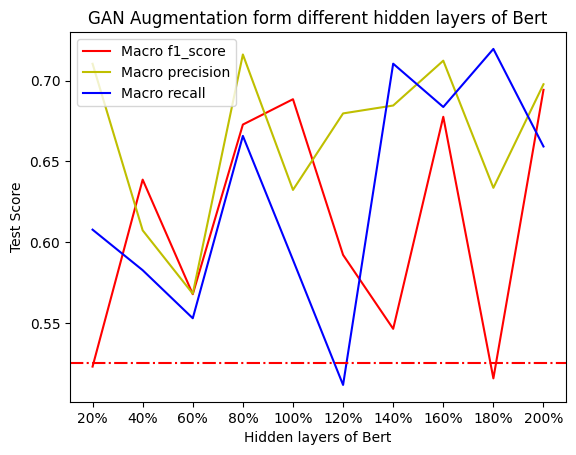

In [20]:
x_label=[str(i*20)+"%" for i in range(1,11)]
import matplotlib.pyplot as plt
# plt.plot(ACCs, label="accuracy")
fig = plt.figure(edgecolor='k', frameon=True)
# fig.patch.set_facecolor('xkcd:blue')
plt.plot(tbk_f1, label="Macro f1_score",color='r')
plt.plot(gan_f1, label="Macro precision",color='y')
plt.plot(hybrid_f1, label="Macro recall",color='b')
plt.axhline(y = 0.525, color = 'r', linestyle = 'dashdot')
plt.xticks([i for i in range(10)],x_label)
plt.xlabel("Hidden layers of Bert")
plt.ylabel("Test Score")
plt.title("GAN Augmentation form different hidden layers of Bert")
plt.legend()
plt.show()